## Pre-processing

In [40]:
import numpy as np
import pandas as pd

UG_courses = ["BOA","BOB","BOC","BOE","BSC"]
Df = pd.read_csv("synthetic_Data_truncated_normal_approach2.csv")
print("size of dataframe:",Df.shape)
Df["COURSE_CODE"] = Df["COURSE_CODE"].fillna('not_taking')
Df = Df[Df.columns].fillna('0')
Df.isnull().sum().sum()

Df = Df.loc[Df['COURSE_CODE'] != 'not_taking']
Df = Df.reset_index()
X = Df[Df.columns.difference(['CODE_DESCR_mast','COURSE_CODE'])]
y = Df[['CODE_DESCR_mast','COURSE_CODE']]
print("X has size:",X.shape, " and y has size:",y.shape)


size of dataframe: (24017, 108)
X has size: (5437, 107)  and y has size: (5437, 2)


In [41]:
## select column that needs to do binary encoding 
subject_course_list = []
for course in UG_courses:
    for i in range(0,16):
        subject_course_list += [course+'subject'+str(i+1)]
profile_title_list = X.columns.difference(subject_course_list)

useless_profile_title_list = ['STU_ID_PROXY','CODE_DESCR_bach','FACULTY_CODE_mast','LANGUAGE_TEST_SCORE','LANGUAGE_TEST_TYPE']+['FACULTY_CODE_mast']
# data cleaning, to sparse, or useless
useful_profile_title_list= list(set(profile_title_list)-set(useless_profile_title_list))
column_title_need_onehotEncode = ['COURSE_CREDITS_REQ_bach','FACULTY_CODE_bach','LOCATION_CODE_bach','top5_bach_bach',
                                  'AGE_BAND','STATE','HOME_LANGUAGE','ATAR_BAND',
                                  'COURSE_CREDITS_REQ_mast','LOCATION_CODE_mast','STUDY_YEAR_mast','N_SUBJECTS_mast']
X.isnull().sum().sum()

print("X has size:",X.shape)


X has size: (5437, 107)


In [42]:

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

####binary encoder
encoder = LabelBinarizer()
# Y_values = encoder.fit_transform(y["COURSE_CODE"].values)
Y_values = y["COURSE_CODE"]
X_part1 = pd.DataFrame({})
for column in column_title_need_onehotEncode:
    column_values=X[column_title_need_onehotEncode][column].astype(str)
    binarised_x = encoder.fit_transform(column_values.values)
    X_part1 = pd.concat([X_part1,pd.DataFrame(binarised_x)],axis=1)
X_part2 = X[list(set(useful_profile_title_list)-set(column_title_need_onehotEncode))]
X_part2 = X_part2.reset_index(drop=True)
X_values = pd.concat([pd.DataFrame(X_part1),X_part2], axis = 1)

print("X has size:",X_values.shape, " and y has size:",Y_values.shape)


X has size: (5437, 90)  and y has size: (5437,)


# modelling without Synthetic



In [67]:

res_dict = pd.DataFrame(data = {"method":[],
            "with Synthetic Data":[],
            "Train set size":[],
            "Test set size":[],
            "order":[],
             "f1_score_weighted":[],
            "accuracy_score":[],
            })
n=10

In [68]:
# take BOA out 
from sklearn.model_selection import train_test_split
import numpy as np
print(X_values.shape,Y_values.shape)
new_Df = pd.concat([pd.DataFrame(X_values),pd.DataFrame(Y_values)],axis = 1)
print(new_Df.shape)
target_Df = new_Df.loc[new_Df['UG_course']==UG_courses[0]]
source_Df =  new_Df.loc[new_Df['UG_course']!=UG_courses[0]]
target_Df = target_Df.drop("UG_course", axis=1)
source_Df = source_Df.drop("UG_course", axis=1)

Y_column_name = 'COURSE_CODE'
Y_target_values = target_Df[Y_column_name].values
X_target_values = target_Df[target_Df.columns.difference([Y_column_name])]
X_target_train, X_test, Y_target_train, Y_test = train_test_split(X_target_values, Y_target_values, test_size=0.2, random_state=27)


(5437, 90) (5437,)
(5437, 91)


In [69]:
def accuracy_at_n(n,recomm,Ytest,order = "1_to_n"):
    res = [0]*n
    total = len(Ytest)
    i =[0]*n
    j = list(range(n))[1:]+[n]
    if order == "n_to_1":
        i= list(range(n))
        i = list(map(lambda x: -1*x, i))[1:]+[0]
        j = [n]*n
    for index, row in recomm.iterrows():
        for each in range(n):
            if Ytest[index] in row.values[i[each]:j[each]]:
                res[each] +=1   
    res = list(map(lambda x:round(x/total,3), res))
    return res,order


In [70]:
from sklearn import metrics

def add_res(n,res,model,method,SynData,X_train,X_test,Y_test,proportion):
    Y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test) 
    n=n
    best_n = np.argsort(-probs, axis=1)[:,:-n]
    #then find the associated SOC code for each prediction
    top_class = cls.classes_[best_n]
    #cast to a new dataframe
    top_class_df = pd.DataFrame(data=top_class)    
#     print(top_class_df[:5])
    acc,order = accuracy_at_n(n,top_class_df,Y_test)
    this_row = {"method":method,
            "with Synthetic Data":SynData,
            "Train set size":int(X_train.shape[0]),
            "Test set size":int(X_test.shape[0]),
            "target-source domain proportion":proportion,
             "f1_score_weighted":metrics.f1_score(Y_test, Y_pred, average="weighted"),
            "accuracy_score":metrics.accuracy_score(Y_test, Y_pred),}
    for i in range(n):
        this_row["accuracy at "+str(i+1)] = acc[i]
    res = res.append(this_row,ignore_index=True)
    return res



In [71]:
import timeit
start = timeit.default_timer()
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
grid_params = {'n_neighbors':[30,40,50,55,60,65,70,75,80,85,90,95,100],
              'weights':['uniform'],
              'metric':['manhattan']}
grid = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
cls  = grid.fit(X_target_train, Y_target_train)
best_parameters = grid.best_params_
print("best parameters are:",best_parameters)
best_result = grid.best_score_
print("best result is :",best_result)
res_dict = add_res(n,res_dict,cls,"KNeighborsClassifier",False,X_target_train,X_test,Y_test,str(X_target_train.shape[0])+":"+"0")

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

Fitting 3 folds for each of 13 candidates, totalling 39 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    6.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    6.3s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters are: {'metric': 'manhattan', 'n_neighbors': 55, 'weights': 'uniform'}
best result is : 0.23430962343096234
Time in seconds:  6.641870599996764


D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [72]:
res_dict

,method,with Synthetic Data,Train set size,Test set size,order,f1_score_weighted,accuracy_score,accuracy at 1,accuracy at 10,accuracy at 2,accuracy at 3,accuracy at 4,accuracy at 5,accuracy at 6,accuracy at 7,accuracy at 8,accuracy at 9,target-source domain proportion
0,KNeighborsClassifier,0.0,956.0,239.0,NaN,0.12924,0.251046,0.251,0.586,0.377,0.402,0.444,0.469,0.494,0.519,0.54,0.577,956:0


In [73]:
import timeit
start = timeit.default_timer()
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
grid_params = {'n_neighbors':[30,40,50,55,60,65,70,75,80,85,90,95,100],
              'weights':['uniform'],
              'metric':['manhattan']}
for i in np.arange(0.9, 0, -0.05):
    
    X_source = source_Df[source_Df.columns.difference([Y_column_name])]
    Y_source = source_Df[Y_column_name]
    X_source_1, X_source_2, Y_source_1, Y_source_2 = train_test_split(X_source, Y_source, test_size=i, random_state=27)
    X_train = pd.concat([X_source_1,pd.DataFrame(X_target_train)])
    Y_train = pd.concat([Y_source_1,pd.DataFrame(Y_target_train)])

    grid = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
    cls  = grid.fit(X_train, Y_train)
    best_parameters = grid.best_params_
    print("best parameters are:",best_parameters)
    best_result = grid.best_score_
    print("best result is :",best_result)
    res_dict = add_res(n,res_dict,cls,"KNeighborsClassifier",False,X_train,X_test,Y_test,str(X_target_train.shape[0])+":"+str(X_source_1.shape[0]))

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.7s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, 

best parameters are: {'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'uniform'}
best result is : 0.25217391304347825
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.8s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, 

best parameters are: {'metric': 'manhattan', 'n_neighbors': 40, 'weights': 'uniform'}
best result is : 0.2657035175879397
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.0s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, 

best parameters are: {'metric': 'manhattan', 'n_neighbors': 40, 'weights': 'uniform'}
best result is : 0.2777161862527716
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.3s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_sele

best parameters are: {'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'uniform'}
best result is : 0.28521825396825395
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.3s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_sele

best parameters are: {'metric': 'manhattan', 'n_neighbors': 40, 'weights': 'uniform'}
best result is : 0.29533213644524237
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.4s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

best parameters are: {'metric': 'manhattan', 'n_neighbors': 40, 'weights': 'uniform'}
best result is : 0.30204918032786887
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.7s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_sele

best parameters are: {'metric': 'manhattan', 'n_neighbors': 40, 'weights': 'uniform'}
best result is : 0.31108597285067874
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.1s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection

best parameters are: {'metric': 'manhattan', 'n_neighbors': 55, 'weights': 'uniform'}
best result is : 0.3125
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    2.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.8s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

best parameters are: {'metric': 'manhattan', 'n_neighbors': 55, 'weights': 'uniform'}
best result is : 0.31881702957426067
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.3s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection

best parameters are: {'metric': 'manhattan', 'n_neighbors': 55, 'weights': 'uniform'}
best result is : 0.32684706597750074
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.0s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

best parameters are: {'metric': 'manhattan', 'n_neighbors': 60, 'weights': 'uniform'}
best result is : 0.32704941445301344
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    2.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    3.0s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

best parameters are: {'metric': 'manhattan', 'n_neighbors': 65, 'weights': 'uniform'}
best result is : 0.3291139240506329
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.9s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection

best parameters are: {'metric': 'manhattan', 'n_neighbors': 70, 'weights': 'uniform'}
best result is : 0.33375796178343947
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.7s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection

best parameters are: {'metric': 'manhattan', 'n_neighbors': 65, 'weights': 'uniform'}
best result is : 0.3345419386028523
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    3.0s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection

best parameters are: {'metric': 'manhattan', 'n_neighbors': 85, 'weights': 'uniform'}
best result is : 0.3340997930558749
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    3.1s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


best parameters are: {'metric': 'manhattan', 'n_neighbors': 85, 'weights': 'uniform'}
best result is : 0.33501425126068846


D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    3.3s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection

best parameters are: {'metric': 'manhattan', 'n_neighbors': 95, 'weights': 'uniform'}
best result is : 0.3341713806830086
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best parameters are: {'metric': 'manhattan', 'n_neighbors': 85, 'weights': 'uniform'}
best result is : 0.3329989969909729
Time in seconds:  44.96986750001088


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    3.5s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [74]:
import timeit
start = timeit.default_timer()
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
grid_params = {'n_neighbors':[30,40,50,55,60,65,70,75,80,85,90,95,100],
              'weights':['uniform'],
              'metric':['manhattan']}
X_source = source_Df[source_Df.columns.difference([Y_column_name])]
Y_source = source_Df[Y_column_name]
X_train = pd.concat([X_source,pd.DataFrame(X_target_train)])
Y_train = pd.concat([Y_source,pd.DataFrame(Y_target_train)])

grid = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
cls  = grid.fit(X_train, Y_train)
best_parameters = grid.best_params_
print("best parameters are:",best_parameters)
best_result = grid.best_score_
print("best result is :",best_result)
res_dict = add_res(n,res_dict,cls,"KNeighborsClassifier",False,X_train,X_test,Y_test,str(X_target_train.shape[0])+":"+str(X_source.shape[0]))


stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best parameters are: {'metric': 'manhattan', 'n_neighbors': 100, 'weights': 'uniform'}
best result is : 0.19372835706040784
Time in seconds:  5.192350499972235


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    4.3s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
res_dict


,method,with Synthetic Data,Train set size,Test set size,order,f1_score_weighted,accuracy_score,accuracy at 1,accuracy at 10,accuracy at 2,accuracy at 3,accuracy at 4,accuracy at 5,accuracy at 6,accuracy at 7,accuracy at 8,accuracy at 9,target-source domain proportion
0,KNeighborsClassifier,0.0,956.0,239.0,NaN,0.129240,0.251046,0.251,0.586,0.377,0.402,0.444,0.469,0.494,0.519,0.540,0.577,956:0
1,KNeighborsClassifier,0.0,1380.0,239.0,NaN,0.146382,0.267782,0.259,0.582,0.360,0.402,0.439,0.464,0.485,0.502,0.540,0.561,956:424
2,KNeighborsClassifier,0.0,1592.0,239.0,NaN,0.158905,0.259414,0.238,0.573,0.347,0.385,0.423,0.448,0.485,0.498,0.515,0.548,956:636
3,KNeighborsClassifier,0.0,1804.0,239.0,NaN,0.158905,0.259414,0.247,0.531,0.356,0.385,0.431,0.448,0.473,0.485,0.510,0.519,956:848
4,KNeighborsClassifier,0.0,2016.0,239.0,NaN,0.146382,0.267782,0.259,0.565,0.364,0.402,0.427,0.456,0.473,0.494,0.510,0.544,956:1060
5,KNeighborsClassifier,0.0,2228.0,239.0,NaN,0.158444,0.259414,0.251,0.548,0.343,0.389,0.431,0.456,0.477,0.494,0.519,0.527,956:1272
6,KNeighborsClassifier,0.0,2440.0,239.0,NaN,0.158444,0.259414,0.255,0.548,0.343,0.381,0.423,0.452,0.481,0.506,0.519,0.531,956:1484
7,KNeighborsClassifier,0.0,2652.0,239.0,NaN,0.157989,0.259414,0.251,0.548,0.339,0.381,0.410,0.448,0.469,0.494,0.519,0.536,956:1696
8,KNeighborsClassifier,0.0,2864.0,239.0,NaN,0.142861,0.259414,0.243,0.577,0.377,0.410,0.448,0.473,0.502,0.527,0.544,0.565,956:1908
9,KNeighborsClassifier,0.0,3077.0,239.0,NaN,0.142861,0.259414,0.255,0.598,0.368,0.402,0.448,0.469,0.490,0.527,0.548,0.573,956:2121


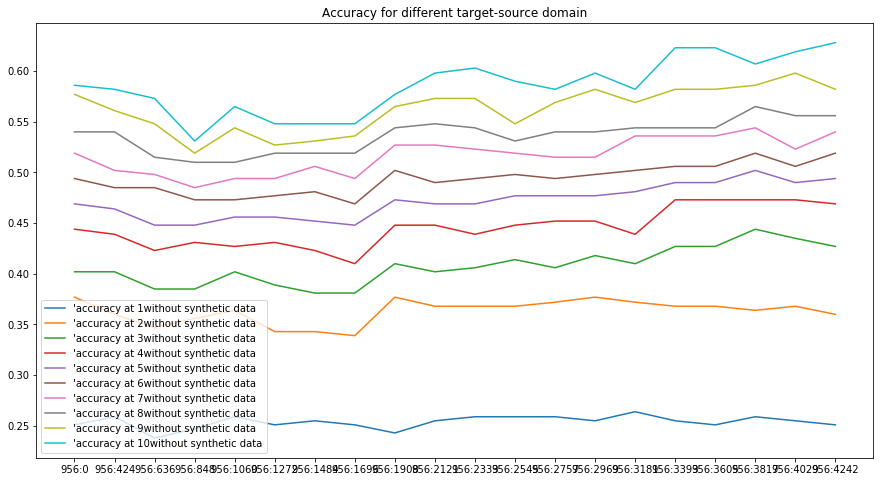

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

x = res_dict['target-source domain proportion']
for i in range(n):
    plt.plot(x, res_dict['accuracy at '+str(i+1)],
             label =  "'accuracy at "+str(i+1)+"without synthetic data")
plt.title('Accuracy for different target-source domain')
plt.legend()
# Display a figure.
plt.show()


# Modelling With Synthetic

In [77]:

X_part2 = X_part2.reset_index(drop = True)
X_part1 = X_part1.reset_index(drop = True)
X_part3 = X[subject_course_list]
X_part3= X_part3.reset_index(drop = True)
X2_values = pd.concat([pd.DataFrame(X_part1),X_part2,X_part3],axis = 1)
from sklearn.model_selection import train_test_split
import numpy as np
print(X2_values.shape,Y_values.shape)
new_Df = pd.concat([pd.DataFrame(X2_values),pd.DataFrame(Y_values)],axis = 1)
print(new_Df.shape)
target_Df = new_Df.loc[new_Df['UG_course']==UG_courses[0]]
source_Df =  new_Df.loc[new_Df['UG_course']!=UG_courses[0]]
target_Df = target_Df.drop("UG_course", axis=1)
source_Df = source_Df.drop("UG_course", axis=1)

Y_column_name = 'COURSE_CODE'
Y_target_values = target_Df[Y_column_name].values
X_target_values = target_Df[target_Df.columns.difference([Y_column_name])]
X_target_train, X_test, Y_target_train, Y_test = train_test_split(X_target_values, Y_target_values, test_size=0.2, random_state=27)


(5437, 170) (5437,)
(5437, 171)


In [78]:
import timeit
start = timeit.default_timer()
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
grid_params = {'n_neighbors':[30,40,50,55,60,65,70,75,80,85,90,95,100],
              'weights':['uniform'],
              'metric':['manhattan']}
grid = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
cls  = grid.fit(X_target_train, Y_target_train)
best_parameters = grid.best_params_
# print("best parameters are:",best_parameters)
best_result = grid.best_score_
# print("best result is :",best_result)
res_dict = add_res(10,res_dict,cls,"KNeighborsClassifier",True,X_train,X_test,Y_test,str(X_target_train.shape[0])+":"+"0")

#-----------------------------------------------------

for i in np.arange(0.9, 0, -0.05):
    
    X_source = source_Df[source_Df.columns.difference([Y_column_name])]
    Y_source = source_Df[Y_column_name]
    X_source_1, X_source_2, Y_source_1, Y_source_2 = train_test_split(X_source, Y_source, test_size=i, random_state=27)
    X_train = pd.concat([X_source_1,pd.DataFrame(X_target_train)])
    Y_train = pd.concat([Y_source_1,pd.DataFrame(Y_target_train)])

    grid = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
    cls  = grid.fit(X_train, Y_train)
#     best_parameters = grid.best_params_
#     print("best parameters are:",best_parameters)
#     best_result = grid.best_score_
#     print("best result is :",best_result)
    res_dict = add_res(10,res_dict,cls,"KNeighborsClassifier",True,X_train,X_test,Y_test,str(X_target_train.shape[0])+":"+str(X_source_1.shape[0]))

#-----------------------------------------------------

X_source = source_Df[source_Df.columns.difference([Y_column_name])]
Y_source = source_Df[Y_column_name]
X_train = pd.concat([X_source,pd.DataFrame(X_target_train)])
Y_train = pd.concat([Y_source,pd.DataFrame(Y_target_train)])

grid = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
cls  = grid.fit(X_train, Y_train)
# best_parameters = grid.best_params_
# print("best parameters are:",best_parameters)
# best_result = grid.best_score_
# print("best result is :",best_result)
res_dict = add_res(10,res_dict,cls,"KNeighborsClassifier",True,X_train,X_test,Y_test,str(X_target_train.shape[0])+":"+str(X_source.shape[0]))


stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

Fitting 3 folds for each of 13 candidates, totalling 39 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.4s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.6s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitting 3 folds for each of 13 candidates, totalling 39 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.8s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exa

Fitting 3 folds for each of 13 candidates, totalling 39 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.5s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\an

Fitting 3 folds for each of 13 candidates, totalling 39 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.8s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\an

Fitting 3 folds for each of 13 candidates, totalling 39 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    3.1s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\an

Fitting 3 folds for each of 13 candidates, totalling 39 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    4.0s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\an

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    5.4s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    4.6s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, 

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    4.3s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitting 3 folds for each of 13 candidates, totalling 39 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    4.7s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\an

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    5.4s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, 

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    6.9s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, 

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    7.7s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    7.4s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    8.6s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    8.5s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitting 3 folds for each of 13 candidates, totalling 39 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    8.1s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\an

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    8.2s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, 

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    8.4s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Time in seconds:  117.12799479998648


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


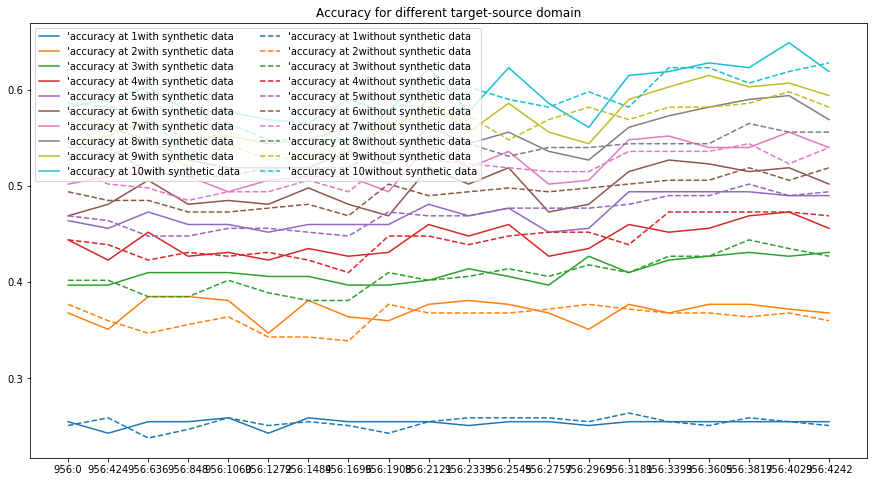

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

x = res_dict.loc[res_dict['with Synthetic Data'] == True]['target-source domain proportion']
for i in range(n):
    plt.plot(x,  res_dict.loc[res_dict['with Synthetic Data'] == True]['accuracy at '+str(i+1)],
             label =  "'accuracy at "+str(i+1)+"with synthetic data")
x2 = res_dict.loc[res_dict['with Synthetic Data'] == False]['target-source domain proportion']
for i in range(n):
    plt.plot(x2,  res_dict.loc[res_dict['with Synthetic Data'] == False]['accuracy at '+str(i+1)],
             label =  "'accuracy at "+str(i+1)+"without synthetic data", linestyle='dashed',)

plt.title('Accuracy for different target-source domain')
plt.legend(loc = 'upper left', ncol=2,)
# Display a figure.
plt.show()

In [65]:
res_dict

,method,with Synthetic Data,Train set size,Test set size,order,f1_score_weighted,accuracy_score,accuracy at 1,accuracy at 10,accuracy at 2,accuracy at 3,accuracy at 4,accuracy at 5,accuracy at 6,accuracy at 7,accuracy at 8,accuracy at 9,target-source domain proportion
0,KNeighborsClassifier,0.0,956.0,239.0,NaN,0.129240,0.251046,0.251,0.586,0.377,0.402,0.444,0.469,0.494,0.519,0.540,0.577,956:0
1,KNeighborsClassifier,0.0,1380.0,239.0,NaN,0.146382,0.267782,0.259,0.582,0.360,0.402,0.439,0.464,0.485,0.502,0.540,0.561,956:424
2,KNeighborsClassifier,0.0,1804.0,239.0,NaN,0.158905,0.259414,0.247,0.531,0.356,0.385,0.431,0.448,0.473,0.485,0.510,0.519,956:848
3,KNeighborsClassifier,0.0,2228.0,239.0,NaN,0.158444,0.259414,0.251,0.548,0.343,0.389,0.431,0.456,0.477,0.494,0.519,0.527,956:1272
4,KNeighborsClassifier,0.0,2652.0,239.0,NaN,0.157989,0.259414,0.251,0.548,0.339,0.381,0.410,0.448,0.469,0.494,0.519,0.536,956:1696
5,KNeighborsClassifier,0.0,3076.0,239.0,NaN,0.142861,0.259414,0.255,0.598,0.368,0.402,0.444,0.464,0.485,0.523,0.548,0.573,956:2120
6,KNeighborsClassifier,0.0,3501.0,239.0,NaN,0.140643,0.259414,0.259,0.590,0.368,0.414,0.448,0.477,0.498,0.519,0.531,0.548,956:2545
7,KNeighborsClassifier,0.0,3925.0,239.0,NaN,0.128520,0.255230,0.255,0.598,0.377,0.418,0.452,0.477,0.498,0.515,0.540,0.582,956:2969
8,KNeighborsClassifier,0.0,4349.0,239.0,NaN,0.134448,0.255230,0.255,0.623,0.368,0.427,0.473,0.490,0.506,0.536,0.544,0.582,956:3393
9,KNeighborsClassifier,0.0,4773.0,239.0,NaN,0.140957,0.259414,0.259,0.607,0.364,0.444,0.473,0.502,0.519,0.544,0.565,0.586,956:3817


In [66]:
res_dict.to_csv('classification result.csv', mode='a', )
